GitHubのソースからcleverhansのライブラリをpipビルドしてください。  
```terminal:
git clone https://github.com/tensorflow/cleverhans
cd cleverhans
pip install -e .
```

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import logging
import numpy as np
import tensorflow as tf

from cleverhans.loss import CrossEntropy
from cleverhans.utils_tf import model_eval
from cleverhans.train import train
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.model_zoo.basic_cnn import ModelBasicCNN

from keras.datasets import mnist
import matplotlib.pyplot as plt
plt.ion()

Using TensorFlow backend.


In [2]:
nb_epochs = 10
batch_size = 32
learning_rate = 0.01

In [3]:
report = AccuracyReport() # クリーン画像の精度やAdversarial Examplesの精度などをまとめるためのクラス
tf.set_random_seed(1234)
sess = tf.InteractiveSession()

In [4]:
# 前処理
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### MNISTの画像shapeを設定する

In [6]:
img_rows, img_cols, nchannels = x_train.shape[1:4] # (28, 28, 1)
nb_classes = y_train.shape[1] # 10

### 画像と正解ラベルを入力するプレースホルダーを設定

In [7]:
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, nchannels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

In [8]:
# 各学習パラメータ、攻撃パラメータを設定
train_params = {
      'nb_epochs': nb_epochs,
      'batch_size': batch_size,
      'learning_rate': learning_rate
  }
eval_params = {'batch_size': batch_size}
fgsm_params = {
  'eps': 0.3,
  'clip_min': 0.,
  'clip_max': 1.
}
rng = np.random.RandomState([2017, 8, 30])

In [8]:
model = ModelBasicCNN('model1', nb_classes=10, nb_filters=32) # 攻撃対象のCNN
preds = model.get_logits(x) # Softmax前の値
loss = CrossEntropy(model, smoothing=0.1) # 内部でsoftmax_cross_entropy_with_logits演算が行われてCrossEntropy Lossが出てくる

**ModelBasicCNNの解説**  
ModelBasicCNNの構造は  
x = Conv2D(32, 8, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(x)  
x = Conv2D(64, 6, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(x)  
x = Conv2D(64, 5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(x)  
x = Flatten()(x)  
logits = Dense(10, kernel_initializer='he_normal')(x)  
の構造とほぼかわらないが、返り値が  
return {self.O_LOGITS: logits, self.O_PROBS: tf.nnsoftmax(logits=logits)}  
となっていて、softmax前の値とsoftmax後の値の２つを返すようになっている。  

In [9]:
def do_eval(preds, x_set, y_set, report_key, is_adv=None):
    '''
    x_setとy_setのペアを与えられたときの正解率を出力する関数。
    preds: logitsのテンソルノード
    report_key: AccuracyReportのメンバ変数の名前のいずれか。(ex. "clean_train_clean_eval", "clean_train_adv_eval" etc)
    is_adv: predsのノードがAdversarial Examplesを生成する経路を通って来るノードであった場合True、クリーン画像の評価であればFalse
            出力のテキストに"adversarial"か"legitimate"と出力されるかを決めるだけなのでそれほど重要な引数ではない。
            （わかりにくいと思うので）TureのときはAdversairal Examplesの評価をしてます。ってことを伝えるときってことです。
    '''
    acc = model_eval(sess, x, y, preds, x_set, y_set, args=eval_params)
    setattr(report, report_key, acc)
    if is_adv is None:
        report_text = None
    elif is_adv:
        report_text = 'adversarial'
    else:
        report_text = 'legitimate'
    if report_text:
        print('Test accuracy on %s examples: %0.4f' % (report_text, acc))

In [10]:
def evaluate():
    '''
    do_evalの特殊ケースをわざわざ関数化している。
    普通にクリーン画像で学習して、クリーン画像でテストします。っていうときの関数です。
    '''
    do_eval(preds, x_test, y_test, 'clean_train_clean_eval', False)

### 単純な訓練（通常画像で訓練して、通常画像でテストする）

学習をする。train()は、sessのグラフを使ってlossを最小にするように動作する。  
学習パラメータは `var_list=model.get_params()` で与える。

In [11]:
train(sess, loss, x_train, y_train, evaluate=evaluate, args=train_params, rng=rng, var_list=model.get_params())

num_devices:  2


[INFO 2019-05-30 11:30:24,812 cleverhans] Epoch 0 took 5.482137203216553 seconds


Test accuracy on legitimate examples: 0.9746


[INFO 2019-05-30 11:30:29,025 cleverhans] Epoch 1 took 3.87585186958313 seconds


Test accuracy on legitimate examples: 0.9757


[INFO 2019-05-30 11:30:33,210 cleverhans] Epoch 2 took 3.8756208419799805 seconds


Test accuracy on legitimate examples: 0.9826


[INFO 2019-05-30 11:30:37,391 cleverhans] Epoch 3 took 3.8840878009796143 seconds


Test accuracy on legitimate examples: 0.9799


[INFO 2019-05-30 11:30:41,570 cleverhans] Epoch 4 took 3.873317003250122 seconds


Test accuracy on legitimate examples: 0.9822


[INFO 2019-05-30 11:30:45,752 cleverhans] Epoch 5 took 3.8773865699768066 seconds


Test accuracy on legitimate examples: 0.9821


[INFO 2019-05-30 11:30:49,924 cleverhans] Epoch 6 took 3.86268949508667 seconds


Test accuracy on legitimate examples: 0.9808


[INFO 2019-05-30 11:30:54,098 cleverhans] Epoch 7 took 3.87605357170105 seconds


Test accuracy on legitimate examples: 0.9803


[INFO 2019-05-30 11:30:58,271 cleverhans] Epoch 8 took 3.869502067565918 seconds


Test accuracy on legitimate examples: 0.9788


[INFO 2019-05-30 11:31:02,442 cleverhans] Epoch 9 took 3.866840124130249 seconds


Test accuracy on legitimate examples: 0.9763


True

### 今学習させた通常の学習済みモデルに対してFGSMでAdversarial Exsamplesを作成した場合の正解率を計算する

In [13]:
fgsm = FastGradientMethod(model, sess=sess)
adv_x = fgsm.generate(x, **fgsm_params) # Adversarial Imageのテンソルノード
preds_adv = model.get_logits(adv_x)
preds_adv = tf.stop_gradient(preds_adv)

# Evaluate the accuracy of the MNIST model on adversarial examples
do_eval(preds_adv, x_test, y_test, 'clean_train_adv_eval', True)

/home/takubuntu/setting_ws/cleverhans/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
/home/takubuntu/setting_ws/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f7054d7e488> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/takubuntu/setting_ws/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f7054d7abf8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of ten

Test accuracy on adversarial examples: 0.1551


### 実際にそのAdversarial Examplesを出力してみる

In [13]:
advImg = sess.run(adv_x, feed_dict={x: x_test, y: y_test})

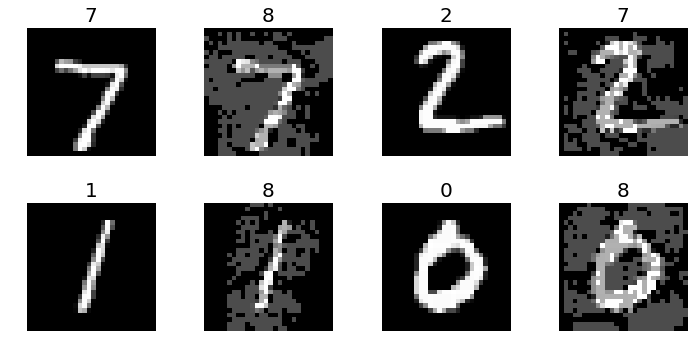

In [14]:
testCleanImg = x_test[:4].reshape(-1, 28, 28, 1)
testAdvImg = advImg[:4].reshape(-1, 28, 28, 1)
cls_c = np.argmax(sess.run(preds, feed_dict={x: testCleanImg}), axis=-1)
cls_a = np.argmax(sess.run(preds_adv, feed_dict={x: testAdvImg}), axis=-1)

fig = plt.figure(figsize=(10, 5))
for i, (ci, ai, cc, ca) in enumerate(zip(testCleanImg, testAdvImg, cls_c, cls_a)):
    plt.subplot(2, 4, 2*i + 1)
    plt.imshow(np.squeeze(ci), cmap='gray')
    plt.title(cc, fontsize=20)
    plt.axis('off')
    plt.subplot(2, 4, 2*i + 2)
    plt.imshow(np.squeeze(ai), cmap='gray')
    plt.title(ca, fontsize=20)
    plt.axis('off')
plt.tight_layout()